<a href="https://colab.research.google.com/github/f-karakus/Topluluk/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install rasterio matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.8 MB/s eta 0:00:00


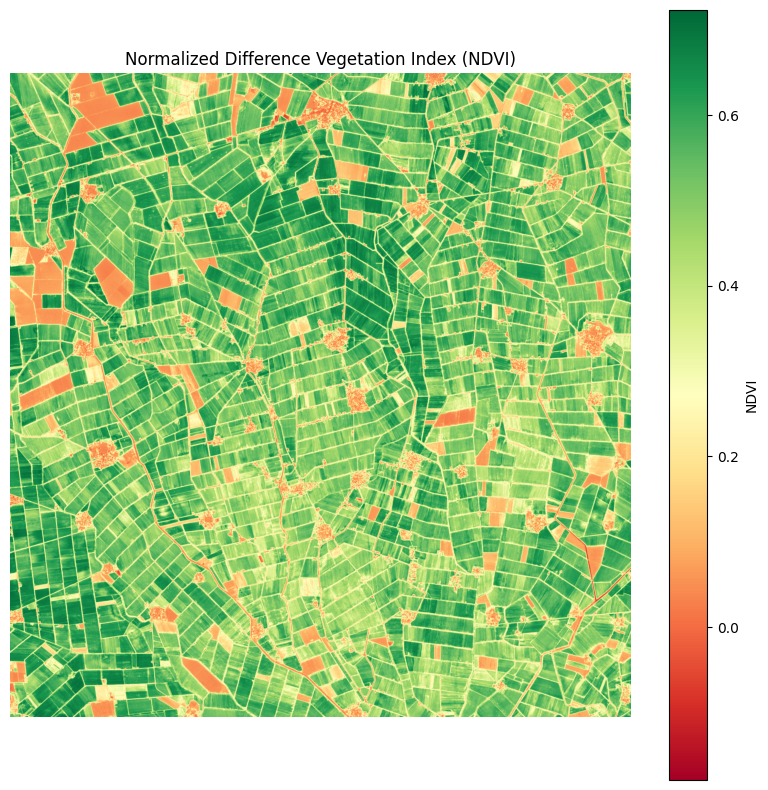

NDVI calculation complete. Output saved at /content/ndvi_python.tif


In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate NDVI
def calculate_ndvi(nir_band, red_band):
    """
    Calculate the Normalized Difference Vegetation Index (NDVI).
    NDVI = (NIR - Red) / (NIR + Red)
    """
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return ndvi

# Load Sentinel-2 bands (Band 4 and Band 8)
band4_path = "/content/10m_Bands/10m_B04.tif"
band8_path = "/content/10m_Bands/10m_B08.tif"

# Open Band 4 (Red) and Band 8 (NIR) using rasterio
with rasterio.open(band4_path) as band4, rasterio.open(band8_path) as band8:
    red = band4.read(1).astype('float32')  # Read the first band and convert to float
    nir = band8.read(1).astype('float32')  # Read the first band and convert to float

    # Calculate NDVI
    ndvi = calculate_ndvi(nir, red)

    # Plot the NDVI
    plt.figure(figsize=(10, 10))
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.colorbar(label='NDVI')
    plt.title('Normalized Difference Vegetation Index (NDVI)')
    plt.axis('off')
    plt.show()

    # Save the NDVI as a GeoTIFF
    ndvi_output_path = "/content/ndvi_python.tif"  # Output file path
    profile = band4.profile
    profile.update(dtype=rasterio.float32, count=1)

    with rasterio.open(ndvi_output_path, 'w', **profile) as dst:
        dst.write(ndvi, 1)

print(f"NDVI calculation complete. Output saved at {ndvi_output_path}")

In [5]:
# Import necessary libraries
import rasterio
from rasterio.enums import Resampling
import os

# Define a function to resample a raster band to match a target resolution
def resample_band(source_path, target_path, reference_path, resampling_method=Resampling.bilinear):
    """
    Resample a raster band to match the resolution of a reference band.

    Parameters:
    - source_path: Path to the 20m band to be resampled.
    - target_path: Path to save the resampled 10m band.
    - reference_path: Path to the 10m reference band (to match resolution).
    - resampling_method: Resampling method to use (default: bilinear).
    """
    # Open the reference band to get target resolution and transform
    with rasterio.open(reference_path) as ref:
        ref_transform = ref.transform
        ref_width = ref.width
        ref_height = ref.height
        ref_crs = ref.crs

    # Open the source band
    with rasterio.open(source_path) as src:
        # Set the output profile to match the reference band
        out_profile = src.profile
        out_profile.update({
            'transform': ref_transform,
            'width': ref_width,
            'height': ref_height,
            'crs': ref_crs,
        })

        # Resample the data
        data = src.read(
            out_shape=(src.count, ref_height, ref_width),
            resampling=resampling_method
        )

        # Write the resampled data to the target path
        with rasterio.open(target_path, 'w', **out_profile) as dst:
            dst.write(data)
    print(f"Resampled {os.path.basename(source_path)} and saved to {target_path}")

# Paths to 20m bands
bands_20m = [
    "/content/20m_Bands/20m_B05.tif",  # 20m Band 5
    "/content/20m_Bands/20m_B06.tif",  # 20m Band 6
    "/content/20m_Bands/20m_B07.tif",  # 20m Band 7
    "/content/20m_Bands/20m_B08A.tif", # 20m Band 8a
    "/content/20m_Bands/20m_B11.tif", # 20m Band 11
    "/content/20m_Bands/20m_B12.tif"  # 20m Band 12
]

# Reference 10m band (to match resolution)
reference_band_10m = "/content/10m_Bands/10m_B02.tif"

# Output folder for resampled bands
output_folder = "/content/resampled_bands/"
os.makedirs(output_folder, exist_ok=True)

# Resample each 20m band to 10m resolution
for band_path in bands_20m:
    band_name = os.path.basename(band_path)
    output_path = os.path.join(output_folder, band_name)
    resample_band(band_path, output_path, reference_band_10m)

print("Resampling complete. Resampled bands are saved in:", output_folder)

Resampled 20m_B05.tif and saved to /content/resampled_bands/20m_B05.tif
Resampled 20m_B06.tif and saved to /content/resampled_bands/20m_B06.tif
Resampled 20m_B07.tif and saved to /content/resampled_bands/20m_B07.tif
Resampled 20m_B08A.tif and saved to /content/resampled_bands/20m_B08A.tif
Resampled 20m_B11.tif and saved to /content/resampled_bands/20m_B11.tif
Resampled 20m_B12.tif and saved to /content/resampled_bands/20m_B12.tif
Resampling complete. Resampled bands are saved in: /content/resampled_bands/


In [6]:
import rasterio
import numpy as np

# Paths to input bands and NDVI
input_bands = [
    "/content/10m_Bands/10m_B02.tif",
    "/content/10m_Bands/10m_B03.tif",
    "/content/10m_Bands/10m_B04.tif",
    "/content/10m_Bands/10m_B08.tif",
    "/content/resampled_bands/R10m_B05.tif",
    "/content/resampled_bands/R10m_B06.tif",
    "/content/resampled_bands/R10m_B07.tif",
    "/content/resampled_bands/R10m_B08A.tif",
    "/content/resampled_bands/R10m_B11.tif",
    "/content/resampled_bands/R10m_B12.tif",
    "/content/ndvi_python.tif"
]

# Output path for the stacked image
output_stack_path = "/content/stacked_image.tif"

# Stack all bands into a single multi-band image
with rasterio.open(input_bands[0]) as src0:
    meta = src0.meta
    meta.update(count=len(input_bands))

    with rasterio.open(output_stack_path, 'w', **meta) as dst:
        for idx, band_path in enumerate(input_bands, start=1):
            with rasterio.open(band_path) as src:
                dst.write(src.read(1), idx)

print(f"Stacked image saved to {output_stack_path}")

Stacked image saved to /content/stacked_image.tif


In [7]:
import geopandas as gpd

# Paths to training and testing shapefiles
train_samples_path = "/content/train_test/train_samples.shp"
test_samples_path = "/content/train_test/test_samples.shp"

# Load shapefiles using GeoPandas
train_samples = gpd.read_file(train_samples_path)
test_samples = gpd.read_file(test_samples_path)

# Print the column names to verify the data
print("Columns in the training shapefile:", train_samples.columns.tolist())
print("Columns in the testing shapefile:", test_samples.columns.tolist())

Columns in the training shapefile: ['id', 'EkimTarihi', 'HasatTarih', 'EkilenAlan', 'UrunAd', 'geometry']
Columns in the testing shapefile: ['id', 'EkimTarihi', 'HasatTarih', 'EkilenAlan', 'UrunAd', 'geometry']


In [8]:
from rasterio.mask import mask
import numpy as np

def extract_training_data(image_path, samples_gdf, label_column):
    """
    Extract raster pixel values and corresponding labels from training samples.
    Handles inhomogeneous shapes by flattening pixel values.

    Parameters:
    - image_path: Path to the stacked raster image.
    - samples_gdf: GeoDataFrame containing training geometries and labels.
    - label_column: The column name in the shapefile containing labels.

    Returns:
    - features: numpy array of pixel values for training.
    - labels: numpy array of labels corresponding to the features.
    """
    with rasterio.open(image_path) as src:
        features = []
        labels = []

        for _, row in samples_gdf.iterrows():
            geometry = [row.geometry]
            label = row[label_column]

            # Mask the image using the sample geometry
            out_image, out_transform = mask(src, geometry, crop=True)

            # Flatten the masked array and remove NaN values
            out_image = out_image.reshape(out_image.shape[0], -1)  # Flatten each band
            valid_pixels = out_image[:, ~np.isnan(out_image).any(axis=0)]  # Keep only valid pixels

            if valid_pixels.shape[1] > 0:  # Ensure there are valid pixels
                features.append(valid_pixels.T)  # Transpose so each row is a feature vector
                labels.extend([label] * valid_pixels.shape[1])  # Repeat label for each pixel

    # Concatenate all features and labels
    features = np.vstack(features)  # Stack into a single numpy array
    labels = np.array(labels)

    return features, labels

# Specify the label column in your shapefile (e.g., the column containing crop types)
label_column = "UrunAd"  # Replace with your column name
stacked_image_path = "/content/stacked_image.tif"

# Extract features and labels
features, labels = extract_training_data(stacked_image_path, train_samples, label_column)

# Check the shapes of the resulting arrays
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (159979, 11)
Labels shape: (159979,)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split features and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Validate the classifier
y_pred = clf.predict(X_val)
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred))

Classification Report on Validation Set:
              precision    recall  f1-score   support

       MISIR       0.99      0.55      0.70      8234
         NAR       0.92      0.27      0.42       241
       PAMUK       0.86      1.00      0.92     23521

    accuracy                           0.88     31996
   macro avg       0.92      0.60      0.68     31996
weighted avg       0.89      0.88      0.86     31996



In [15]:
import rasterio
import numpy as np

def classify_image(image_path, model, output_path, class_mapping):
    """
    Classify a raster image using a trained machine learning model.

    Parameters:
    - image_path: Path to the stacked raster image.
    - model: Trained machine learning model.
    - output_path: Path to save the classified raster.
    - class_mapping: Dictionary mapping class labels (strings) to integer codes.
    """
    with rasterio.open(image_path) as src:
        profile = src.profile
        profile.update(count=1, dtype=rasterio.uint8)  # Update profile for a single-band classification result

        # Read the entire raster image
        image = src.read()
        image_reshaped = image.reshape(image.shape[0], -1).T  # Reshape for prediction

        # Predict classes for the entire image
        predictions = model.predict(image_reshaped)

        # Convert string labels to integer codes using the class mapping
        predictions_int = np.vectorize(class_mapping.get)(predictions)

        # Reshape predictions to match raster dimensions
        predictions_image = predictions_int.reshape(src.height, src.width)

        # Save the classified raster
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(predictions_image.astype(rasterio.uint8), 1)

    print(f"Classified image saved to {output_path}")

# Paths
stacked_image_path = "/content/stacked_image.tif"  # Path to the stacked image
classified_image_path = "/content/classified_image.tif"  # Path to save the classified raster

# Define the class mapping (e.g., 'PAMUK' -> 1, 'MISIR' -> 2, 'NAR' -> 3)
class_mapping = {
    'PAMUK': 1,
    'MISIR': 2,
    'NAR': 3
}

# Classify the image
classify_image(stacked_image_path, clf, classified_image_path, class_mapping)

Classified image saved to /content/classified_image.tif


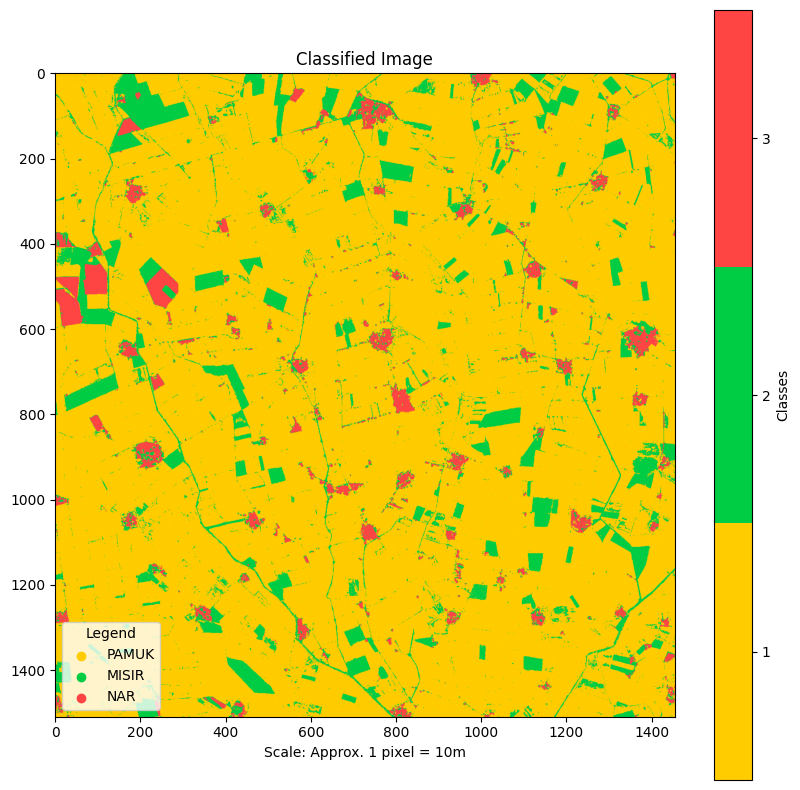

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rasterio

# Define class colors and labels
class_colors = ["#ffcc00", "#00cc44", "#ff4444"]  # Example: yellow, green, red
class_labels = ["PAMUK", "MISIR", "NAR"]  # Example labels corresponding to classes

# Load the classified raster
with rasterio.open(classified_image_path) as src:
    classified_image = src.read(1)  # Read the first (and only) band

# Create a thematic map using the defined colors
cmap = ListedColormap(class_colors)
plt.figure(figsize=(10, 10))
plt.imshow(classified_image, cmap=cmap)
plt.colorbar(ticks=range(1, len(class_colors) + 1), label="Classes")
plt.clim(0.5, len(class_colors) + 0.5)  # Ensure colorbar matches class indices
plt.title("Classified Image")

# Add legend
for i, label in enumerate(class_labels):
    plt.scatter([], [], color=class_colors[i], label=label)
plt.legend(loc="lower left", title="Legend")

# Add scale bar (simple approximation)
plt.xlabel("Scale: Approx. 1 pixel = 10m")
plt.show()

In [19]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize

def rasterize_shapefile(shapefile_path, reference_raster_path, label_column, class_mapping, output_raster_path):
    """
    Rasterize a shapefile to match the dimensions and resolution of a reference raster.

    Parameters:
    - shapefile_path: Path to the shapefile to rasterize.
    - reference_raster_path: Path to the reference raster to match dimensions and resolution.
    - label_column: Column in the shapefile that contains the class labels.
    - class_mapping: Dictionary mapping string class labels to numeric codes.
    - output_raster_path: Path to save the rasterized output.
    """
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)

    # Map string labels to numeric codes using the class_mapping dictionary
    gdf['numeric_label'] = gdf[label_column].map(class_mapping)
    if gdf['numeric_label'].isnull().any():
        raise ValueError("Some class labels in the shapefile do not match the class_mapping. Please check your data.")

    # Read the reference raster
    with rasterio.open(reference_raster_path) as ref:
        transform = ref.transform
        shape = (ref.height, ref.width)
        crs = ref.crs

    # Create (geometry, numeric_label) pairs for rasterization
    shapes = [(geom, label) for geom, label in zip(gdf.geometry, gdf['numeric_label'])]

    # Rasterize the shapefile
    rasterized = rasterize(
        shapes,
        out_shape=shape,
        transform=transform,
        fill=0,  # Background value
        dtype=rasterio.uint8
    )

    # Save the rasterized output
    with rasterio.open(
        output_raster_path, 'w',
        driver='GTiff',
        height=shape[0],
        width=shape[1],
        count=1,
        dtype=rasterio.uint8,
        crs=crs,
        transform=transform
    ) as dst:
        dst.write(rasterized, 1)

    print(f"Rasterized shapefile saved to {output_raster_path}")

# Paths
test_samples_path = "/content/train_test/test_samples.shp"  # Path to test samples shapefile
reference_raster_path = "/content/classified_image.tif"  # Path to the classified raster
rasterized_test_samples_path = "/content/train_test/rasterized_test_samples.tif"  # Path to save the rasterized test samples

# Define the class mapping (e.g., 'PAMUK' -> 1, 'MISIR' -> 2, 'NAR' -> 3)
class_mapping = {
    'PAMUK': 1,
    'MISIR': 2,
    'NAR': 3
}

# Rasterize the test samples
rasterize_shapefile(test_samples_path, reference_raster_path, "UrunAd", class_mapping, rasterized_test_samples_path)

Rasterized shapefile saved to /content/train_test/rasterized_test_samples.tif


In [20]:
import rasterio
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score

def calculate_accuracy_metrics(classified_raster_path, ground_truth_raster_path, class_mapping):
    """
    Perform accuracy assessment between a classified raster and ground truth raster.

    Parameters:
    - classified_raster_path: Path to the classified raster.
    - ground_truth_raster_path: Path to the ground truth raster.
    - class_mapping: Dictionary mapping class labels (strings) to integer codes.

    Returns:
    - Metrics: Dictionary containing accuracy metrics.
    """
    with rasterio.open(classified_raster_path) as classified, rasterio.open(ground_truth_raster_path) as ground_truth:
        classified_data = classified.read(1)
        ground_truth_data = ground_truth.read(1)

    # Ensure both rasters have the same dimensions
    assert classified_data.shape == ground_truth_data.shape, "Rasters have different dimensions!"

    # Flatten the arrays for comparison
    classified_flat = classified_data.flatten()
    ground_truth_flat = ground_truth_data.flatten()

    # Mask out background values (assume 0 is the background)
    mask = (ground_truth_flat > 0)
    classified_flat = classified_flat[mask]
    ground_truth_flat = ground_truth_flat[mask]

    # Calculate confusion matrix
    classes = list(class_mapping.values())  # Integer class codes
    conf_matrix = confusion_matrix(ground_truth_flat, classified_flat, labels=classes)

    # Calculate accuracy metrics
    overall_accuracy = accuracy_score(ground_truth_flat, classified_flat)
    kappa_coefficient = cohen_kappa_score(ground_truth_flat, classified_flat)
    producer_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)  # Row-wise accuracy
    user_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=0)  # Column-wise accuracy

    # Print results
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Overall Accuracy: {overall_accuracy:.2f}")
    print(f"Kappa Coefficient: {kappa_coefficient:.2f}")
    print("Producer's Accuracy (per class):", producer_accuracy)
    print("User's Accuracy (per class):", user_accuracy)

    return {
        "confusion_matrix": conf_matrix,
        "overall_accuracy": overall_accuracy,
        "kappa_coefficient": kappa_coefficient,
        "producer_accuracy": producer_accuracy,
        "user_accuracy": user_accuracy
    }

# Paths
classified_raster_path = "/content/classified_image.tif"  # Path to the classified raster
ground_truth_raster_path = "/content/train_test/rasterized_test_samples.tif"  # Path to the rasterized ground truth

# Define the class mapping (same as in classify_image.py)
class_mapping = {
    'PAMUK': 1,
    'MISIR': 2,
    'NAR': 3
}

# Perform accuracy assessment
metrics = calculate_accuracy_metrics(classified_raster_path, ground_truth_raster_path, class_mapping)

Confusion Matrix:
[[27590   302    37]
 [  183  3675   652]
 [  129    42    25]]
Overall Accuracy: 0.96
Kappa Coefficient: 0.84
Producer's Accuracy (per class): [0.98786208 0.81485588 0.12755102]
User's Accuracy (per class): [0.98881801 0.91440657 0.03501401]
